In [393]:
!pip install optuna

In [394]:
# EDA for
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
import gc

# Metrics
from sklearn.metrics import (
    mean_squared_error
)

# from tensorflow.keras.metrics import RootMeanSquaredError

# # Models

# import keras_tuner
# from keras import *
# from scikeras.wrappers import KerasRegressor
# from keras import Sequential
# from keras.layers import (
#     Dense, 
#     Dropout,
# )

# from keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold,
    train_test_split,
    GridSearchCV,
    KFold,
)
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

from catboost import *

# Any
import warnings
warnings.filterwarnings('ignore')

In [395]:
class CFG:
    TARGET = 'nivel_y'
    N_FOLDS = 3
    RANDOM_STATE = 87
# MOVE
    # TRAIN_PATH_1 = './data/2024_08_10 16_20_01.csv'
    # TRAIN_PATH_2 = './data/2024_08_10 18_25_52.csv'
    # TRAIN_PATH_3 = './data/2024_08_10 14_31_28.csv'

    # TEST_PATH_1 = './test/test1.csv'
    # TEST_PATH_2 = './test/test2.csv'
    # # TEST_PATH_3 = './test/test3.csv'\
    # # TEST_PATH_4 = './test/test4.csv'
# ENDMOVE

# STABLE DAY1
    TRAIN_PATH = './data/Stable/Day1/2024_09_02_6hz 19_09-20.csv'
    TRAIN_PATH_AIR = './data/Stable/Day1/2024_09_02_6hz 19_09-20_air.csv'

    TEST_PATH_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11.csv'
    TEST_PATH_AIR_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11_air.csv'
# ENDSTABLE DAY1
# # STABLE DAY2
    # TRAIN_PATH_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1.csv'
    # TRAIN_PATH_AIR_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1_air.csv'
    # TRAIN_PATH_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2.csv'
    # TRAIN_PATH_AIR_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2_air.csv'

    # TEST_PATH_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35.csv'
    # TEST_PATH_AIR_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35_air.csv'
# ENDSTABLE DAY2
# STABLE DAY3
    # TRAIN_PATH = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01.csv'
    # TRAIN_PATH_AIR_1 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_1_air.csv'
    # TRAIN_PATH_AIR_2 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_2_air.csv'
    # TRAIN_PATH_AIR_3 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_3_air.csv'

    # TEST_PATH_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35.csv'
    # TEST_PATH_AIR_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35_air.csv'
# ENDSTABLE DAY3
# STABLE DAY4
    # TRAIN_PATH_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_1.csv'
    # TRAIN_PATH_2 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2.csv'
    # TRAIN_PATH_AIR_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2_air.csv'

    # TEST_PATH_3HZ_1 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_1.csv'
    # TEST_PATH_3HZ_2 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_2.csv'
    # TEST_PATH_AIR_3HZ = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_air.csv'
# ENDSTABLE DAY4


In [396]:
# # MOVE
#     # df_end = pd.read_csv(CFG.TRAIN_PATH_1)
#     # df_start = pd.read_csv(CFG.TRAIN_PATH_2)
#     # df_start_0 = pd.read_csv(CFG.TRAIN_PATH_3)

#     # df_test_1 = pd.read_csv(CFG.TEST_PATH_1)
#     # df_test_2 = pd.read_csv(CFG.TEST_PATH_2)
# # ENDMOVE
# # 1HZ
# df_1 = pd.read_csv(CFG.TRAIN_PATH_1)
# df_air_1 = pd.read_csv(CFG.TRAIN_PATH_AIR_1)
# df_2 = pd.read_csv(CFG.TRAIN_PATH_2)
# df_air_2 = pd.read_csv(CFG.TRAIN_PATH_AIR_2)

# df_test_1 = pd.read_csv(CFG.TEST_PATH_1HZ)
# df_test_air_1 = pd.read_csv(CFG.TEST_PATH_AIR_1HZ)

# temp = pd.concat([df_1,df_2],ignore_index=True)
# temp_air = pd.concat([df_air_1,df_air_2],ignore_index=True)
# # 1HZ

# 6HZ
df_1 = pd.read_csv(CFG.TRAIN_PATH)
df_air_1 = pd.read_csv(CFG.TRAIN_PATH_AIR)

df_test6 = pd.read_csv(CFG.TEST_PATH_6HZ)
df_test_air6 = pd.read_csv(CFG.TEST_PATH_AIR_6HZ)
# # 6HZ

# # 0.3HZ
# df_1 = pd.read_csv(CFG.TRAIN_PATH)
# df_air_1 = pd.read_csv(CFG.TRAIN_PATH_AIR_1)
# df_air_2 = pd.read_csv(CFG.TRAIN_PATH_AIR_2)
# df_air_3 = pd.read_csv(CFG.TRAIN_PATH_AIR_3)


# df_test3 = pd.read_csv(CFG.TEST_PATH_03HZ)
# df_test_air3 = pd.read_csv(CFG.TEST_PATH_AIR_03HZ)

# temp = pd.concat([df_air_1,df_air_2,df_air_3],ignore_index=True)



# # 3HZ
# df_1 = pd.read_csv(CFG.TRAIN_PATH_1)
# df_2 = pd.read_csv(CFG.TRAIN_PATH_2)
# df_air_1 = pd.read_csv(CFG.TRAIN_PATH_AIR_1)

# df_test_1 = pd.read_csv(CFG.TEST_PATH_3HZ_1)
# df_test_2 = pd.read_csv(CFG.TEST_PATH_3HZ_2)
# df_test_air_1 = pd.read_csv(CFG.TEST_PATH_AIR_3HZ)

# temp = pd.concat([df_1,df_2],ignore_index=True)
# temp_test = pd.concat([df_test_1,df_test_2],ignore_index=True)

In [397]:
# 3HZ
# train = temp[:8000].copy()
# train['air_temp'] = df_air_1['temperature'][:8000]
# test = temp_test[:4700].copy()
# test['air_temp'] = df_test_air_1['temperature'][:4700]



# 1HZ
# train_1 = df_1.copy()
# train_1['air_temp'] = df_air_1['temperature']
# train_2 = df_2.copy()
# train_2['air_temp'] = df_air_2['temperature']

# train = pd.concat([train_1,train_2],ignore_index=True)
# train = train[:5500]

# test = df_test_1[:3000].copy()
# test['air_temp'] = df_test_air_1['temperature'][:3000]

# 6HZ
train = df_1[:4700].copy()
train['air_temp'] = df_air_1['temperature'][:4700]
test = df_test6[:5700].copy()
test['air_temp'] = df_test_air6['temperature'][:5700]

# 0.3HZ
# train = df_1[300:1000].copy()
# train['air_temp'] = temp['temperature'][300:1000]
# train = train.reset_index(drop=True)

# test = df_test3[:1000].copy()
# test['air_temp'] = df_test_air3['temperature'][:1000]



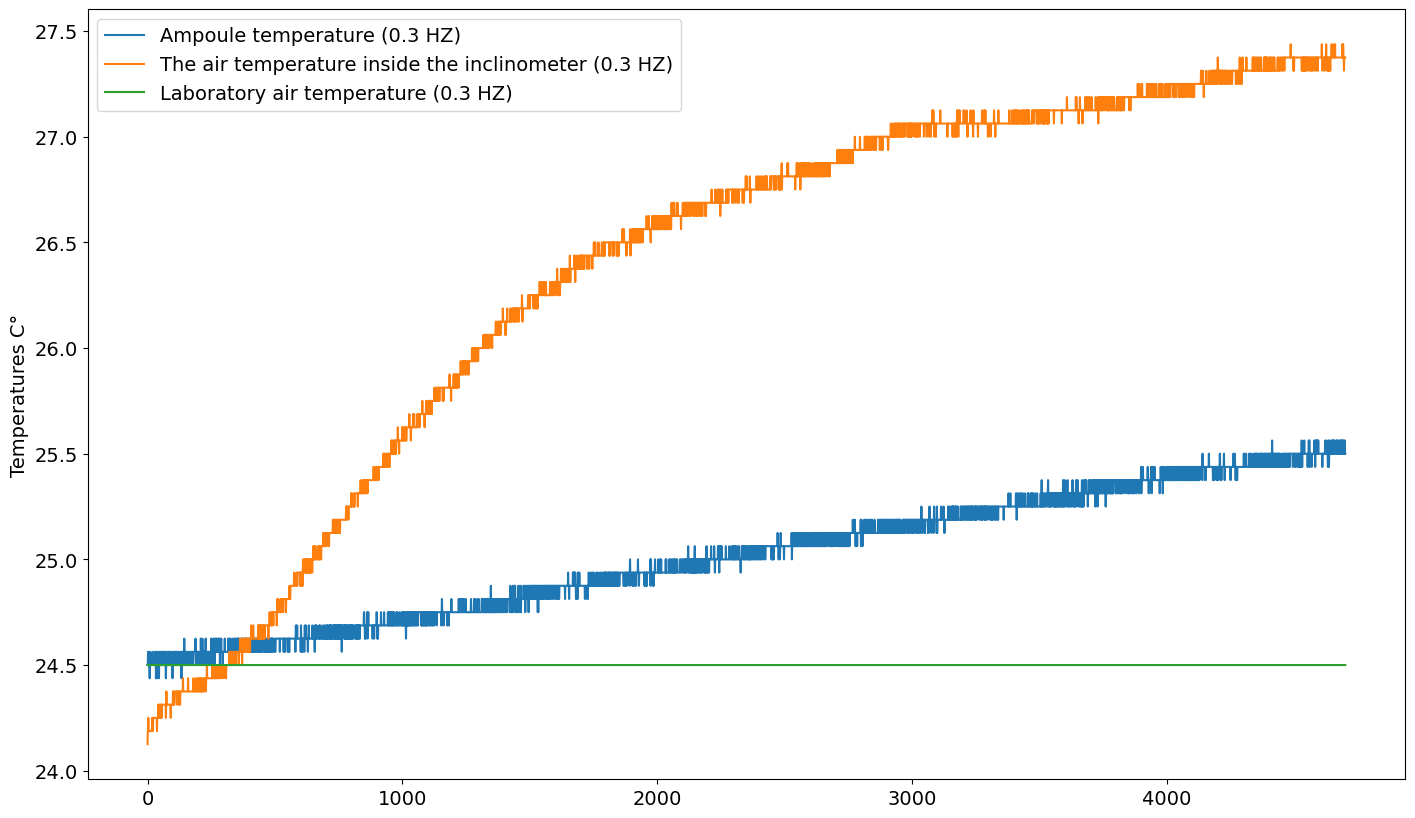

In [398]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(train.index,train[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (0.3 HZ)',
                'The air temperature inside the inclinometer (0.3 HZ)',
                'Laboratory air temperature (0.3 HZ)'],fontsize=14)

plt.show()

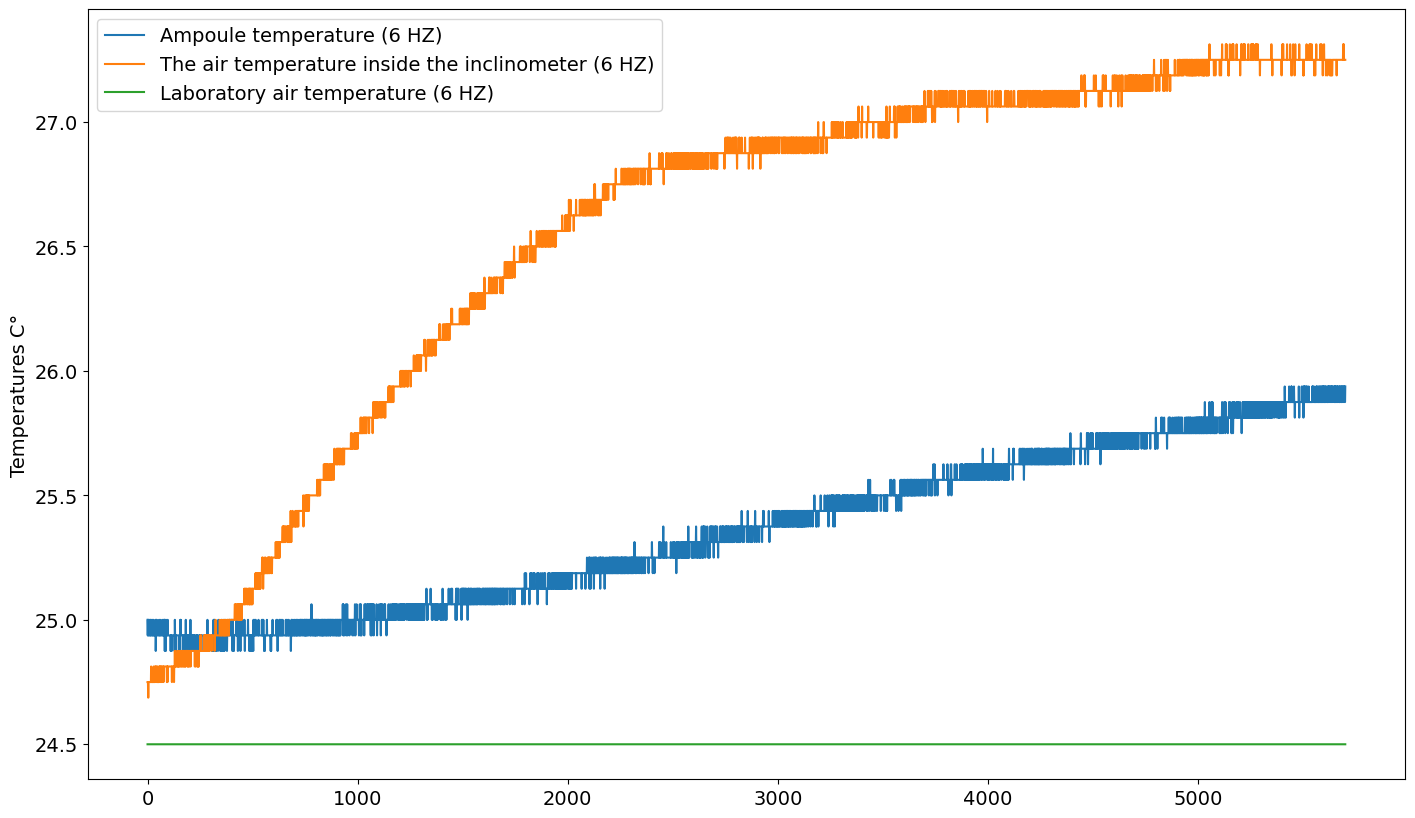

In [399]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(test.index,test[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (6 HZ)',
                'The air temperature inside the inclinometer (6 HZ)',
                'Laboratory air temperature (6 HZ)'],fontsize=14)

plt.show()

<Axes: >

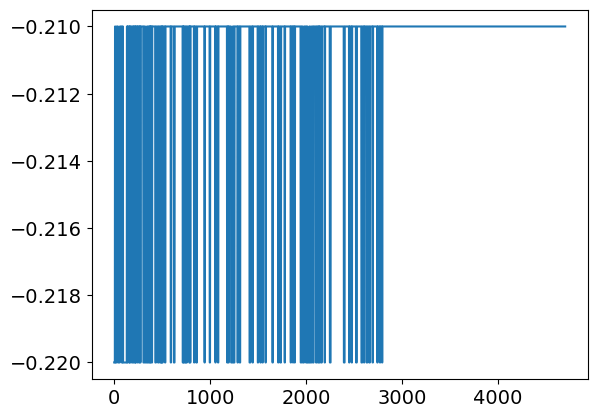

In [400]:
train[CFG.TARGET].plot()

<Axes: >

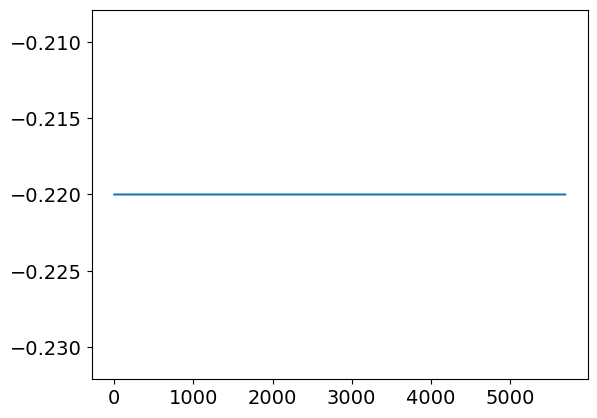

In [401]:
test[CFG.TARGET].plot()

In [402]:
train = train.loc[(train['watch_indicator'] != 'False') &
                (train['watch_indicator'] != 'None')]
train = train.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

test = test.loc[(test['watch_indicator'] != 'False') &
                (test['watch_indicator'] != 'None')]
test = test.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])


In [409]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)


# train['center_bubbles_px'] = train['center_bubbles_px'].loc[(train['center_bubbles_px'] > -5) & (train['center_bubbles_px'] < 10)]
# test['center_bubbles_px'] = test['center_bubbles_px'].loc[(test['center_bubbles_px'] > -5) & (test['center_bubbles_px'] < 10)]

# for i in train.columns:
#     if i not in [CFG.TARGET, 'temperature', 'air_temp','center_bubbles_px']:
#         train[i] = train[i].loc[(train[i] > -200) & (train[i] < 200)]
#         test[i] = test[i].loc[(test[i] > -200) & (test[i] < 200)]

# for i in train.columns:
#     if i not in [CFG.TARGET, 'temperature', 'air_temp']:
#         train[i] = train[i].interpolate(method='nearest', limit_direction='forward')
#         test[i] = test[i].interpolate(method='nearest', limit_direction='forward')

In [410]:
# def agg_features(df, suffix=''):
#     X = pd.DataFrame()    
#     X[suffix+"median"] = df.median(axis=1)
#     X[suffix+"mean"] = df.mean(axis=1)
#     X[suffix+"std"] = df.std(axis=1)
#     X[suffix+"max"] = df.max(axis=1)
#     X[suffix+"min"] = df.min(axis=1)
#     X["length"] = np.sqrt(df['1']**2 - df['center_bubbles_px']**2)
#     return X

In [411]:
# train = train.join(agg_features(train), how='left')
# test = test.join(agg_features(test), how='left')

In [412]:
# STEP = 35

# for i in train.columns:
#     # if i not in [CFG.TARGET, 'temperature']:
#     if i not in [CFG.TARGET, 'temperature', 'air_temp']:
#         train[i] = train[i].rolling(STEP).median()
#         train[i] = train[i][STEP:]
#         test[i] = test[i].rolling(STEP).median()
#         test[i] = test[i][STEP:]

In [413]:

# train = train.fillna(0.0)
# test = test.fillna(0.0)
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features = train.drop([CFG.TARGET], axis=1)
target = train[CFG.TARGET]

<Axes: >

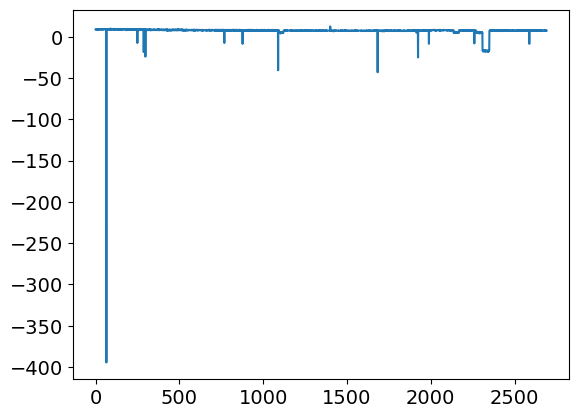

In [414]:
features['center_bubbles_px'].plot()

# Linear Regression for Ct

slope (95%): -1.641153 +/- 0.083808
intercept (95%): 48.761657 +/- 2.097056


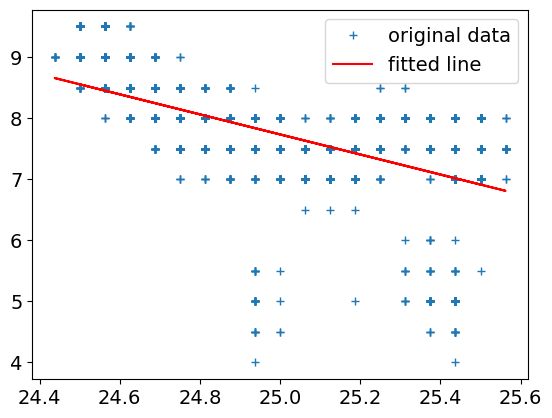

In [374]:
from scipy import stats

res = stats.linregress(features['temperature'], features['center_bubbles_px'])

from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))

ts = tinv(0.05, len(features['temperature'])-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")

print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")
# print(f"fitted {res.intercept + res.slope*features['temperature']}")
plt.plot(features['temperature'], features['center_bubbles_px'], '+', label='original data')
plt.plot(features['temperature'], res.intercept + res.slope*features['temperature'], 'r', label='fitted line')
plt.legend()
plt.show()

In [352]:
df_cf = train.copy()

for i in df_cf.columns:
    if i not in [CFG.TARGET, 'temperature', 'air_temp']:
        res = stats.linregress(df_cf['temperature'], df_cf[i])
        df_cf[i] = res.intercept + res.slope*df_cf['temperature']

df_cf[[CFG.TARGET, 'temperature', 'air_temp']] = 0

In [353]:
df_cf.head()

,center_bubbles_px,nivel_y,temperature,1,2,3,4,5,6,7,...,92,93,94,95,96,97,98,99,100,air_temp
0,-0.239468,0,0,-190.341816,-190.317054,-189.196516,-188.951179,-188.204806,-187.078951,-186.133384,...,10.384830,20.957476,24.352672,33.513419,36.828808,45.990589,49.12852,56.595205,59.586828,0
1,-0.239468,0,0,-190.341816,-190.317054,-189.196516,-188.951179,-188.204806,-187.078951,-186.133384,...,10.384830,20.957476,24.352672,33.513419,36.828808,45.990589,49.12852,56.595205,59.586828,0
2,-0.077998,0,0,-189.966047,-189.941889,-188.822631,-188.579523,-187.829880,-186.699654,-185.760187,...,11.478954,21.989720,25.371438,34.493063,37.790812,46.885409,50.00096,57.448898,60.420633,0
3,-0.077998,0,0,-189.966047,-189.941889,-188.822631,-188.579523,-187.829880,-186.699654,-185.760187,...,11.478954,21.989720,25.371438,34.493063,37.790812,46.885409,50.00096,57.448898,60.420633,0
4,-0.239468,0,0,-190.341816,-190.317054,-189.196516,-188.951179,-188.204806,-187.078951,-186.133384,...,10.384830,20.957476,24.352672,33.513419,36.828808,45.990589,49.12852,56.595205,59.586828,0


In [354]:
temp = train.copy()

temp -= df_cf

features = temp.drop([CFG.TARGET], axis=1)
target = temp[CFG.TARGET]

# Multiple Linear Regression

In [355]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(features, target)
pred_l = reg.predict(test.drop(columns=CFG.TARGET))

In [356]:
np.sqrt(mean_squared_error(test[CFG.TARGET], pred_l))

0.009999999999999981

In [357]:
dif_l = test[CFG.TARGET] - (pred_l)
dif_l.mean()

-0.009999999999999983

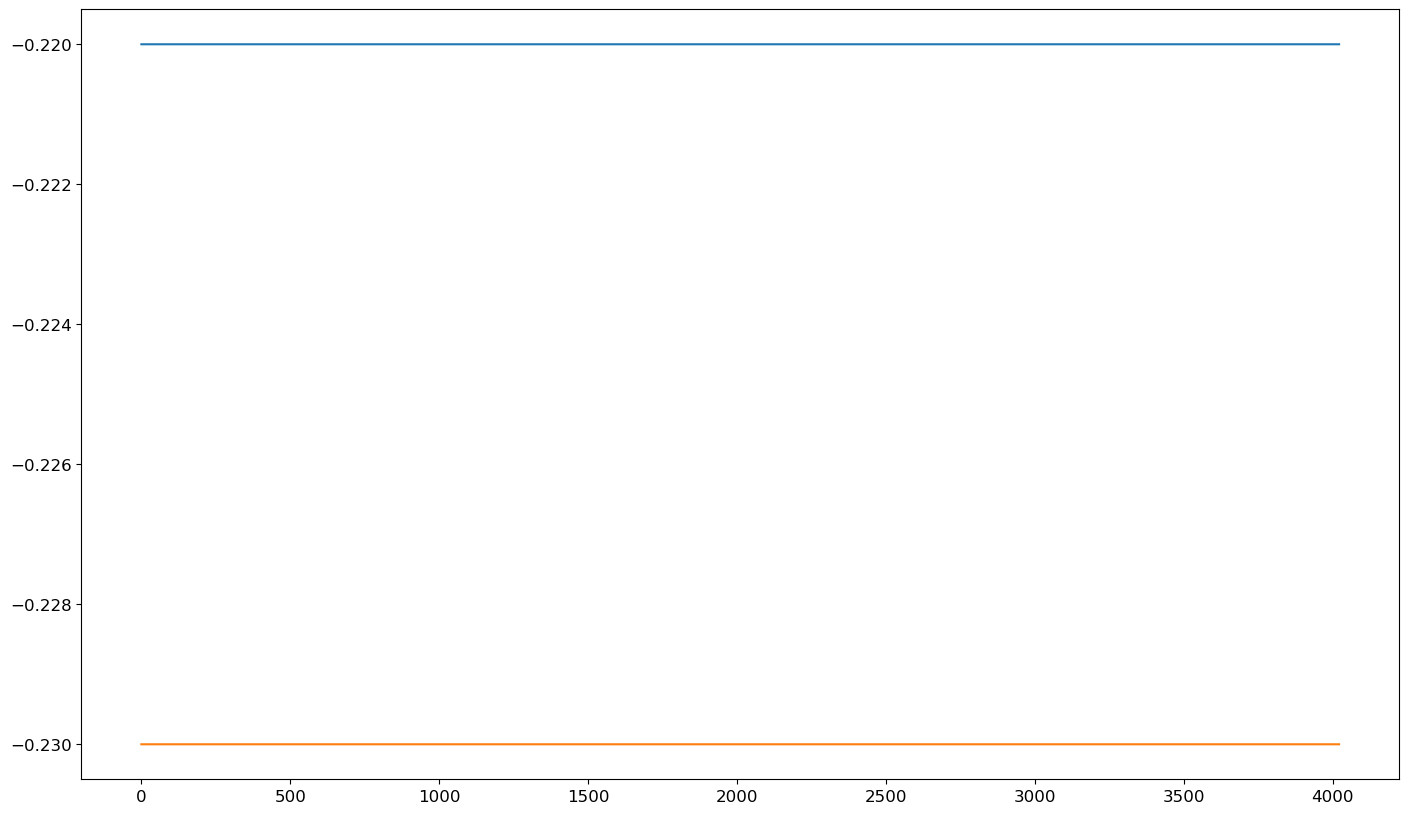

In [358]:
pd.DataFrame(pred_l).plot(figsize=(17,10),legend=False,fontsize=12);test[CFG.TARGET].plot();

<Axes: >

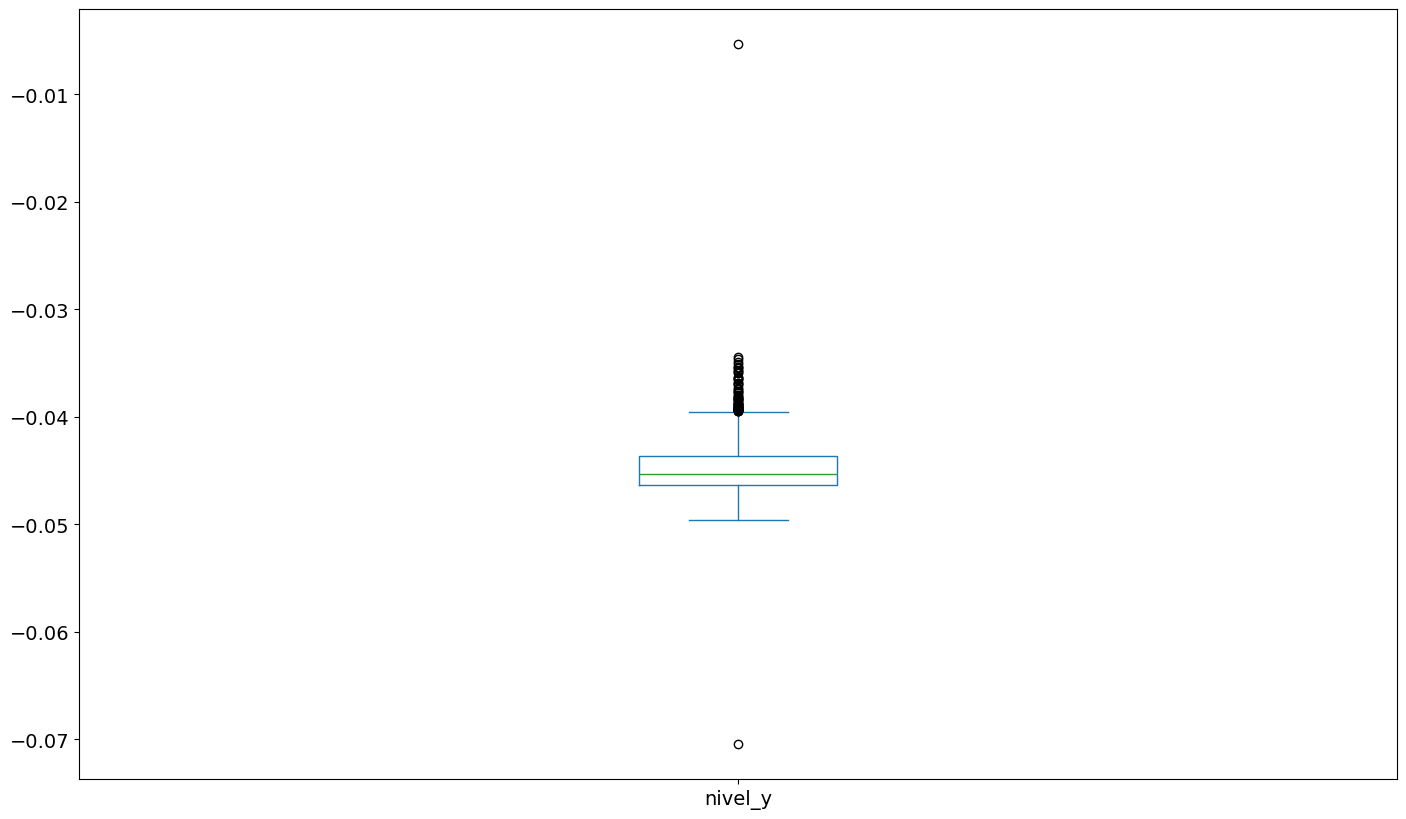

In [336]:
dif_l.plot(figsize=(17,10),kind='box')

# Cat

In [49]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [50]:
def build_catboost(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'random_strength': trial.suggest_float('random_strength', .1, 1., log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', .1, 1., log=True),
        'bootstrap_type':'Bayesian',
        'task_type': 'GPU',
        'loss_function':'RMSE'
    }

    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(features_train, target_train),
        model.get_params(),
        verbose=False
    )
    return np.min(cv_data['test-RMSE-mean'])

In [51]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=10)

[I 2024-09-13 18:51:35,360] A new study created in memory with name: no-name-8fa31eae-88f5-41bb-9010-f18a078f0b44


Training on fold [0/3]
bestTest = 0.2076830225
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2075017345
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:52:39,793] Trial 0 finished with value: 0.207630534853301 and parameters: {'learning_rate': 1.7558316959642398e-05, 'depth': 9, 'l2_leaf_reg': 0.36519920372037096, 'random_strength': 0.1590221198725975, 'bagging_temperature': 0.2546023015431566}. Best is trial 0 with value: 0.207630534853301.


bestTest = 0.2077068475
bestIteration = 999
Training on fold [0/3]
bestTest = 0.1784703716
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1782827865
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:53:01,988] Trial 1 finished with value: 0.1784236972736946 and parameters: {'learning_rate': 0.00016944237001327602, 'depth': 5, 'l2_leaf_reg': 0.18463593689927482, 'random_strength': 0.2792037194810662, 'bagging_temperature': 0.7383215364856419}. Best is trial 1 with value: 0.1784236972736946.


bestTest = 0.1785179337
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2111271608
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2109456553
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:53:22,957] Trial 2 finished with value: 0.2110718112440512 and parameters: {'learning_rate': 1.0561220046406817e-06, 'depth': 5, 'l2_leaf_reg': 0.4756401556582314, 'random_strength': 0.12556852850799344, 'bagging_temperature': 0.17700783282764235}. Best is trial 1 with value: 0.1784236972736946.


bestTest = 0.2111426176
bestIteration = 999
Training on fold [0/3]
bestTest = 0.1854209262
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1852356521
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:53:48,021] Trial 3 finished with value: 0.18538191012115432 and parameters: {'learning_rate': 0.00013141317452702167, 'depth': 6, 'l2_leaf_reg': 0.7185298659217881, 'random_strength': 0.21895310868843668, 'bagging_temperature': 0.22187781971028708}. Best is trial 1 with value: 0.1784236972736946.


bestTest = 0.1854891521
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2110655171
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2108839249
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:54:01,246] Trial 4 finished with value: 0.21101003048403652 and parameters: {'learning_rate': 1.3460676608259913e-06, 'depth': 1, 'l2_leaf_reg': 0.1375293916205423, 'random_strength': 0.22188158383604986, 'bagging_temperature': 0.9394563208355974}. Best is trial 1 with value: 0.1784236972736946.


bestTest = 0.2110806494
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2095880251
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2094068773
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:54:51,110] Trial 5 finished with value: 0.2095339841213765 and parameters: {'learning_rate': 8.38896406962415e-06, 'depth': 8, 'l2_leaf_reg': 0.15857744764785187, 'random_strength': 0.719785601281431, 'bagging_temperature': 0.14652642827359474}. Best is trial 1 with value: 0.1784236972736946.


bestTest = 0.20960705
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2029127206
bestIteration = 999
Training on fold [1/3]
bestTest = 0.202727726
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:55:09,086] Trial 6 finished with value: 0.20285715673804905 and parameters: {'learning_rate': 4.0805774301576415e-05, 'depth': 3, 'l2_leaf_reg': 0.25177469871043384, 'random_strength': 0.1908435689280714, 'bagging_temperature': 0.38805338198352396}. Best is trial 1 with value: 0.1784236972736946.


bestTest = 0.2029310236
bestIteration = 999
Training on fold [0/3]
bestTest = 0.1319832022
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1317878127
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:56:03,835] Trial 7 finished with value: 0.13195979643689015 and parameters: {'learning_rate': 0.00047203914766012094, 'depth': 7, 'l2_leaf_reg': 0.12405167415915808, 'random_strength': 0.6117918596087812, 'bagging_temperature': 0.11075605640527406}. Best is trial 7 with value: 0.13195979643689015.


bestTest = 0.1321083744
bestIteration = 999
Training on fold [0/3]
bestTest = 0.1881867181
bestIteration = 999
Training on fold [1/3]
bestTest = 0.18800221
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:56:35,921] Trial 8 finished with value: 0.18814582667578597 and parameters: {'learning_rate': 0.00011642169348516944, 'depth': 7, 'l2_leaf_reg': 0.3055116708912768, 'random_strength': 0.19757292211571745, 'bagging_temperature': 0.47932658359875424}. Best is trial 7 with value: 0.13195979643689015.


bestTest = 0.188248552
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2049580182
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2047737226
bestIteration = 999
Training on fold [2/3]


[I 2024-09-13 18:56:49,030] Trial 9 finished with value: 0.20490193744132765 and parameters: {'learning_rate': 3.075149210595876e-05, 'depth': 1, 'l2_leaf_reg': 0.5765024771069347, 'random_strength': 0.35953342112511016, 'bagging_temperature': 0.3696709781714342}. Best is trial 7 with value: 0.13195979643689015.


bestTest = 0.2049740715
bestIteration = 999


In [52]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.00047203914766012094, 'depth': 7, 'l2_leaf_reg': 0.12405167415915808, 'random_strength': 0.6117918596087812, 'bagging_temperature': 0.11075605640527406}
Best RMSE: 0.13195979643689015


# CB
- Best hyperparameters: {'learning_rate': 0.00047203914766012094, 'depth': 7, 'l2_leaf_reg': 0.12405167415915808, 'random_strength': 0.6117918596087812, 'bagging_temperature': 0.11075605640527406}
- Best RMSE: 0.13195979643689015

# NON-CB
- Best hyperparameters: {'learning_rate': 0.008681151630685426, 'depth': 1, 'l2_leaf_reg': 0.3978744610671192, 'random_strength': 0.32718187893217754, 'bagging_temperature': 0.337077824517019}
- Best RMSE: 0.003096857994992059

In [53]:
rmses = []
preds = []
skf = KFold(n_splits=20)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train[CFG.TARGET])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in [CFG.TARGET]]]
    y_train = train.loc[train_idx, CFG.TARGET]
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, CFG.TARGET]
    X_test = test[X_train.columns]



    X_train_pool = Pool(X_train, y_train)
    X_valid_pool = Pool(X_valid, y_valid)
    X_test_pool = Pool(X_test)


    model = CatBoostRegressor(
        loss_function='RMSE',
        learning_rate=0.00047203914766012094,
        iterations=10000,
        depth=7,
        l2_leaf_reg=0.12405167415915808,
        random_strength=0.6117918596087812,
        bagging_temperature=0.11075605640527406,
        bootstrap_type='Bayesian',
        task_type='GPU',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=200)

    pred_valid = model.predict(X_valid_pool)
    preds.append(model.predict(X_test_pool))

    rmse = mean_squared_error(y_valid, pred_valid)**.5
    rmses.append(rmse)
    
    del X_train, y_train, X_valid, y_valid, X_test
    gc.collect()

    print(f'Fold {fold+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.median(rmse):.5f} +/- {np.std(rmse):.5f}')

### Fold 1 Training ###
0:	learn: 0.0031803	test: 0.0059179	best: 0.0059179 (0)	total: 14.1ms	remaining: 2m 20s
500:	learn: 0.0030917	test: 0.0057101	best: 0.0057101 (500)	total: 6.81s	remaining: 2m 9s
1000:	learn: 0.0030313	test: 0.0055758	best: 0.0055758 (1000)	total: 13.6s	remaining: 2m 1s
1500:	learn: 0.0029892	test: 0.0054934	best: 0.0054934 (1500)	total: 20.4s	remaining: 1m 55s
2000:	learn: 0.0029580	test: 0.0054348	best: 0.0054348 (2000)	total: 27.1s	remaining: 1m 48s
2500:	learn: 0.0029339	test: 0.0053896	best: 0.0053896 (2500)	total: 34.1s	remaining: 1m 42s
3000:	learn: 0.0029121	test: 0.0053559	best: 0.0053559 (3000)	total: 42.6s	remaining: 1m 39s
3500:	learn: 0.0028907	test: 0.0053366	best: 0.0053366 (3500)	total: 50s	remaining: 1m 32s
4000:	learn: 0.0028721	test: 0.0053231	best: 0.0053231 (4000)	total: 57s	remaining: 1m 25s
4500:	learn: 0.0028544	test: 0.0053132	best: 0.0053132 (4500)	total: 1m 3s	remaining: 1m 17s
5000:	learn: 0.0028377	test: 0.0053065	best: 0.0053063 (498

KeyboardInterrupt: 

In [740]:
model.save_model('model_temp_stable_non_6')

In [741]:
pd.DataFrame(rmses).median()

0    0.003062
dtype: float64

In [377]:
# model = CatBoostRegressor()
# model.load_model('model_temp_stable_non_6')

In [742]:
r = model.predict(test[train.columns])

In [743]:
print(np.sqrt(mean_squared_error(test[CFG.TARGET], r)))
print(np.sqrt(mean_squared_error(test[CFG.TARGET], r+C0)))

0.00913023589578349
0.006010216389356656


In [744]:
dif = test[CFG.TARGET] - (r)
print(dif.mean())
(test[CFG.TARGET] - (r+C0)).mean()

-0.009074616882192063


0.005925383117807931

In [733]:
C0 = -0.015

In [386]:
C0 = (test[CFG.TARGET] - r).mean()

In [387]:
C0

-0.00903026435236793

In [381]:
np.sqrt(mean_squared_error(test[CFG.TARGET], r+C0))

0.006009731969400444

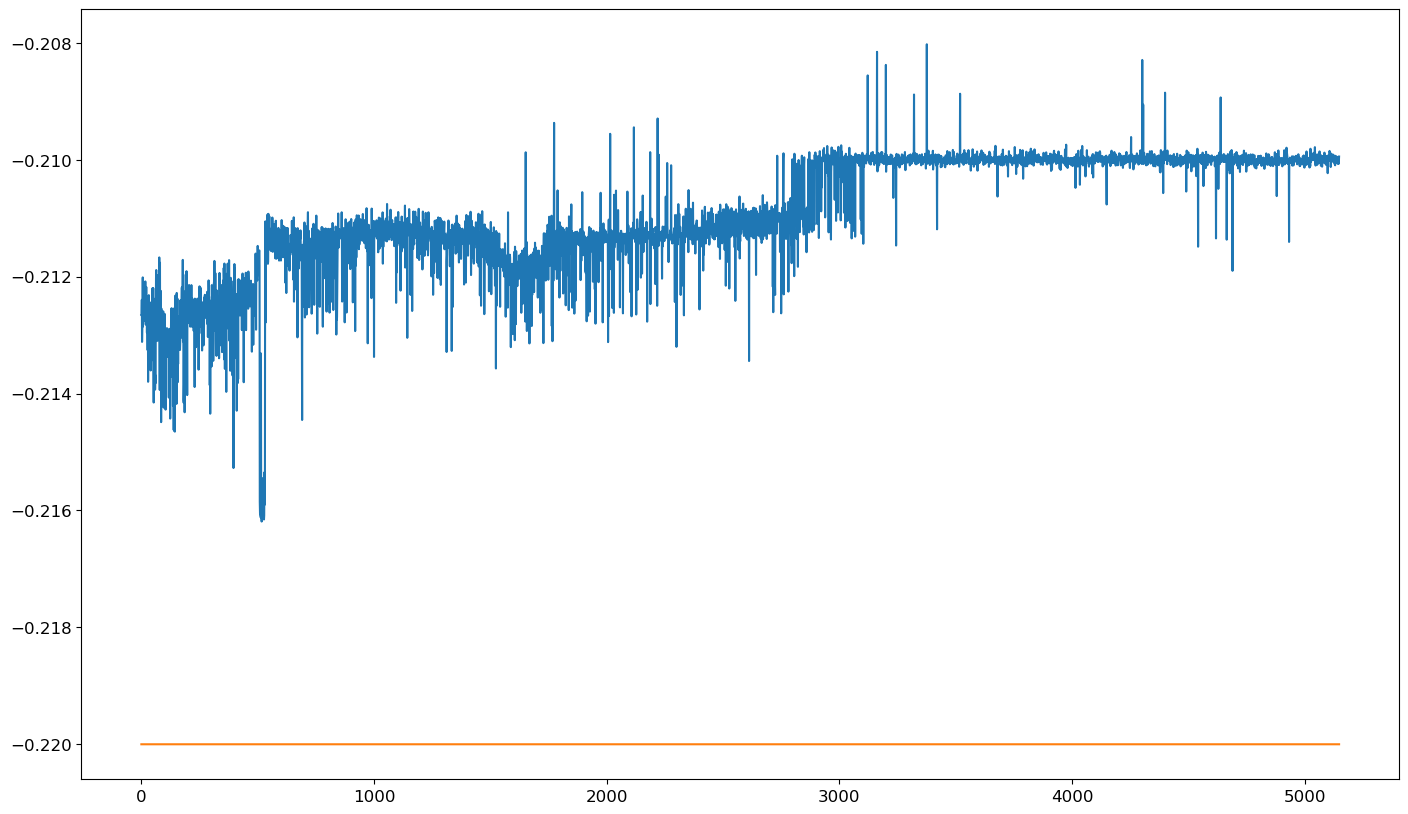

In [746]:
pd.DataFrame(r).plot(figsize=(17,10),legend=False,fontsize=12);test[CFG.TARGET].plot();

<Axes: >

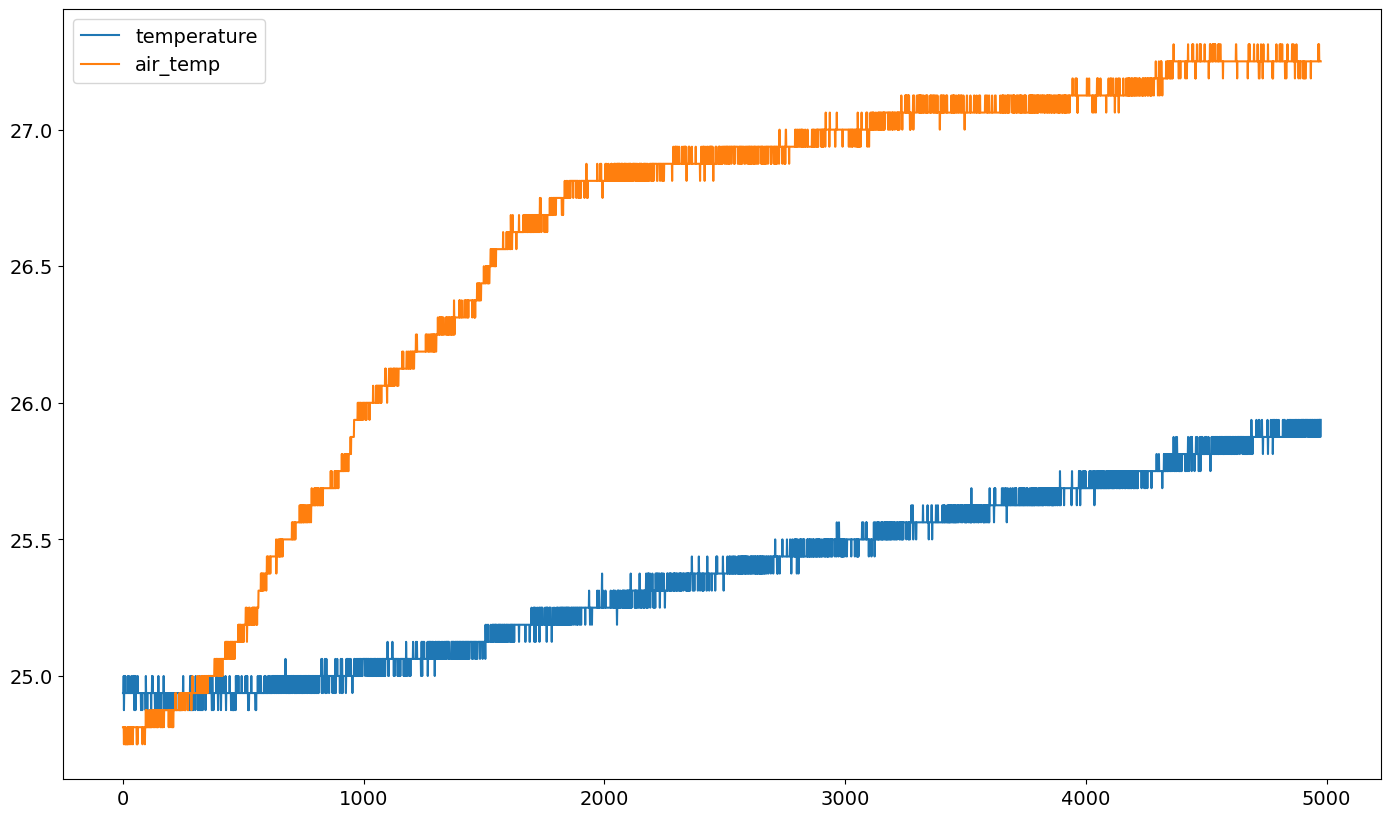

In [635]:
test['temperature'].plot(legend=True,figsize=(17,10));test['air_temp'].plot(legend=True)

<Axes: >

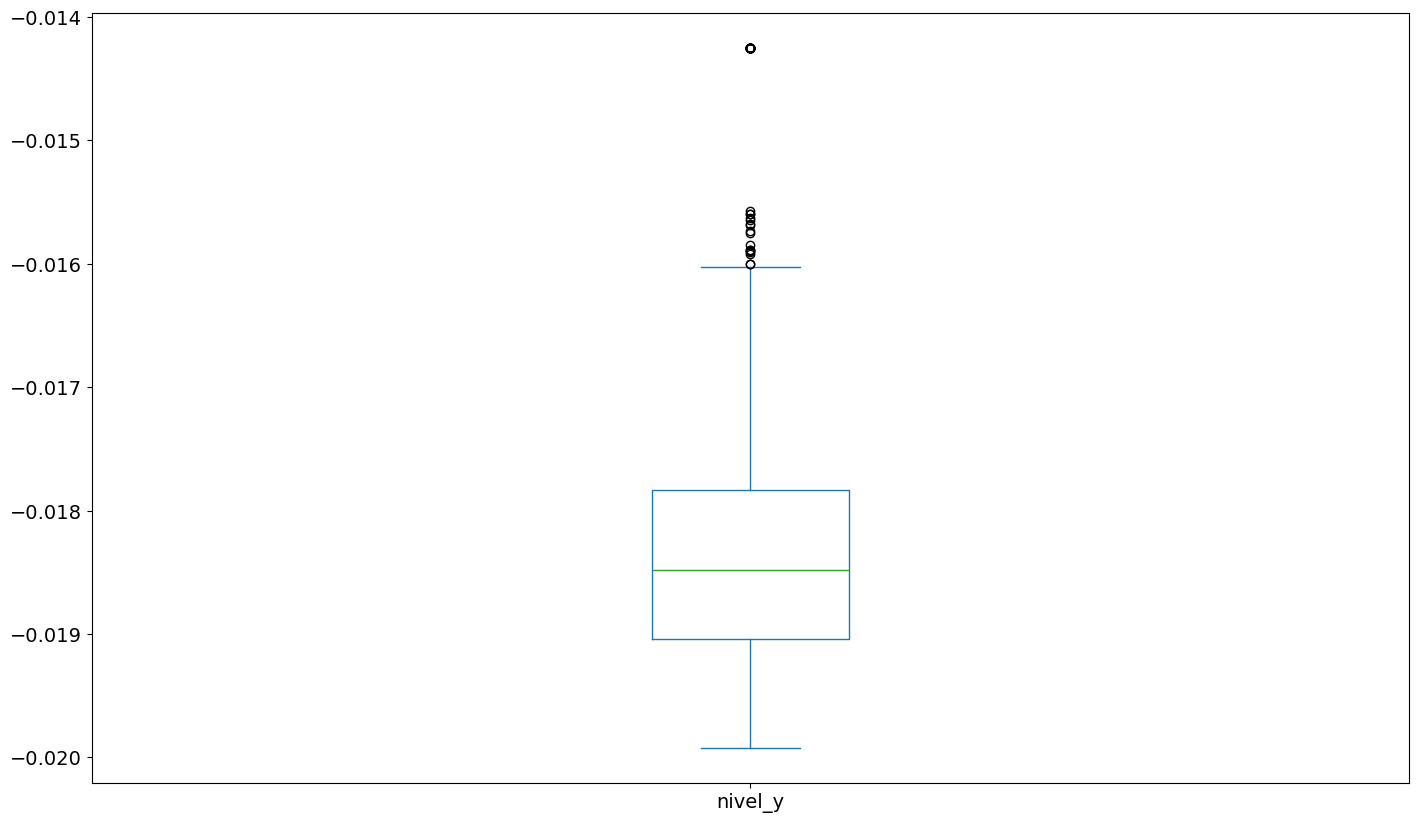

In [300]:
dif.plot(figsize=(17,10),kind='box')

# NN

In [176]:
features

,center_bubbles_px,temperature,1,2,3,4,5,6,7,8,...,98,99,100,air_temp,median,mean,std,max,min,length
0,0.0,24.5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1250,0.00,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,24.5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1875,0.00,0.000000,0.000000,0.0,0.0,0.000000
2,0.0,24.5625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1875,0.00,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,24.5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.2500,0.00,0.000000,0.000000,0.0,0.0,0.000000
4,9.0,24.5000,-173.0,-173.0,-172.0,-172.0,-171.0,-170.0,-170.0,-168.0,...,58.0,64.0,65.0,24.1875,-130.75,-99.259928,75.171977,65.0,-173.0,172.765737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865,8.0,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-167.0,-167.0,-166.0,...,105.0,106.0,106.0,27.4375,-130.50,-93.838558,83.503742,106.0,-173.0,172.814930
4866,7.5,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-169.0,-168.0,-167.0,...,102.0,106.0,106.0,27.4375,-130.50,-94.516442,83.343909,106.0,-173.0,172.837351
4867,7.5,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-169.0,-167.0,-166.0,...,105.0,107.0,108.0,27.4375,-130.50,-94.516442,83.343909,108.0,-173.0,172.837351
4868,7.5,25.5625,-173.0,-173.0,-172.0,-172.0,-171.0,-170.0,-168.0,-167.0,...,106.0,111.0,112.0,27.4375,-128.50,-89.237596,87.291004,112.0,-173.0,172.837351


In [124]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [125]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [126]:
def build_model():
    model_nn = Sequential()
    model_nn.add(Dense(32, activation='tanh'))
    model_nn.add(Dense(1))
    model_nn.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=[RootMeanSquaredError()])
    return model_nn

In [ ]:
model_nn = build_model()

model_nn.fit(
    features_train,
    target_train,
    epochs=100
)

In [19]:
def build_neural_network(hp):    
    model = Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=128, max_value=1024, step=64),
                activation=hp.Choice("activation", ["tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [20]:
build_neural_network(keras_tuner.HyperParameters())

In [21]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_root_mean_squared_error', 'min'),
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
)

In [22]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [23]:
X_train, X_val, y_train, y_val = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [24]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Trial 5 Complete [00h 09m 02s]
val_root_mean_squared_error: 0.020136764893929165

Best val_root_mean_squared_error So Far: 0.020136764893929165
Total elapsed time: 00h 21m 15s


In [25]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [26]:
callback = EarlyStopping(monitor='loss', patience=100)

In [27]:
best_NN.fit(
    X_train,  
    y_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000


333/333 [==============================] - 1s 3ms/step - loss: 0.0445 - root_mean_squared_error: 0.2110
Epoch 2/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771
Epoch 3/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741
Epoch 4/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726
Epoch 5/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708
Epoch 6/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697
Epoch 7/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676
Epoch 8/10000
333/333 [==============================] - 1s 3ms/step - loss: 0.0043 - root_mean_squared_error: 0.0659
Epoch 9/10000
333/333 [==============================] - 1s 3ms/step -

In [28]:
ynew = best_NN.predict(features)
class_probabilities = np.hstack((1-ynew, ynew))

444/444 [==============================] - 1s 1ms/step


In [189]:
target

0      -0.01
1      -0.01
2      -0.01
3      -0.01
4      -0.01
        ... 
7663    1.50
7664    1.50
7665    1.50
7666    1.50
7667    1.50
Name: nivel_y, Length: 7668, dtype: float64

In [190]:
pred = pd.DataFrame(ynew)

In [191]:
np.sqrt(mean_squared_error(target, pred))

0.026182164995101342

<Axes: >

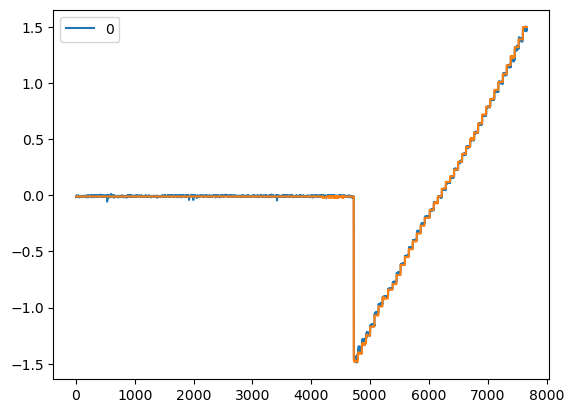

In [192]:
pred.plot(); target.plot()

In [193]:
dif = target - pred[0]

In [194]:
dif.std()

0.025986164382474093

In [195]:
dif.mean()

-0.0032113998970169882

# Test NN

In [198]:
test_df = pd.read_csv('./test/test1.csv')

In [199]:
test_df = test_df.loc[(test_df['watch_indicator'] != 'False') &
(test_df['watch_indicator'] != 'None')]
test_df = test_df.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

In [200]:
test_df = test_df.reset_index(drop=True)
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        test_df[i] = test_df[i].interpolate()

In [201]:
test_df = test_df.join(agg_features(test_df), how='left')

In [202]:
for i in test_df.columns:
    if i not in [CFG.TARGET, 'temperature']:
        print(i)
        test_df[i] = test_df[i].rolling(5).median()
        test_df[i].fillna(0, inplace=True)

center_bubbles_px
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
median
mean
std
max
min


In [203]:
features = test_df.drop([CFG.TARGET],axis=1)
target = test_df[CFG.TARGET]

In [204]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [205]:
pred = best_NN.predict(features)

19/19 [==============================] - 0s 833us/step


In [206]:
pred = pd.DataFrame(pred)

In [207]:
np.sqrt(mean_squared_error(target, pred))

0.3847204189031395

<Axes: >

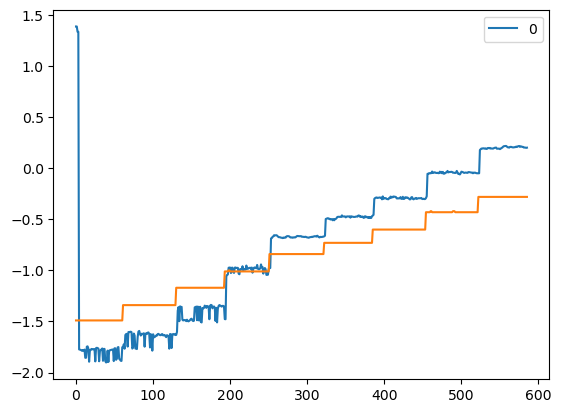

In [208]:
pd.DataFrame(pred).plot();target.plot()